# Sensitivity check for choice of impact function threshold

In this code, we (qualitatively) examine how sensitive modelling outcomes are to the choice of impact function thresholds. For this, we vary the threshold over a range (0.2 - 0.8) and test these resulting impacts (aai_agg) for both hazard types (CF, TC) on 2 countries (PHL, SOM)

In [1]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard

# select country here
cntry = 'Philippines'

In [2]:
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_TC'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_TCIMPF_HAZUS[row.se_seismo], axis=1)

for col in ['iso3', 'sector', 'valfis']:
    gdf_bem_subcomps.pop(col)

exp = Exposures(gdf_bem_subcomps)
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf = exp.gdf[~np.isnan(
    exp.gdf.latitude)]  # drop nan centroids

### Load TC hazard and cut to exposure extent

In [3]:
# load TC hazard phl
if cntry == 'Somalia':
    reg = 'IO'
elif cntry == 'Philippines':
    reg = 'WP'
else:
    reg = print('no country-basin assingment found')

haz_TC_dir = Path('/cluster/work/climate/meilers/climada/data/hazard/present')
haz_TC = TropCyclone.from_hdf5(haz_TC_dir.joinpath(f'TC_{reg}_0150as_MIT_H08.hdf5'))

In [4]:
TC = haz_TC.select(extent=(
    exp.gdf['longitude'].min(), exp.gdf['longitude'].max(), exp.gdf['latitude'].min(), exp.gdf['latitude'].max()))

### Prepare TC impact functions

In [5]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_tc_step = ImpactFuncSet()

In [6]:
def get_TC_step_func(impf_set, threshold, haz_type, unit):
    for imp_id in impf_set.get_ids(haz_type=haz_type):
        impf_set.get_func(fun_id=imp_id)
        y = impf_set.get_func(fun_id=imp_id)[0].intensity
        x = impf_set.get_func(fun_id=imp_id)[0].mdd
        thresh = np.interp(threshold, x, y)
        impf_set_tc_step.append(
                    ImpactFunc.from_step_impf(
                        intensity=(0,  thresh, thresh *10),
                        haz_type=haz_type,
                        impf_id=imp_id,
                        intensity_unit=unit
                    )
        )
    return impf_set_tc_step

In [7]:
impf_set_tc = vulnerability.IMPF_SET_TC_HAZUS

In [8]:
building_thresh = np.arange(0.05, 0.95, 0.05)

### Caluclate impacts

In [9]:
aai_agg_dict = {}
for thresh in building_thresh:
    impf_set = get_TC_step_func(impf_set=impf_set_tc, threshold=thresh, haz_type='TC', unit='m/s')
    impact = ImpactCalc(exp, impf_set, TC).impact()
    aai_agg_dict[thresh] = impact.aai_agg

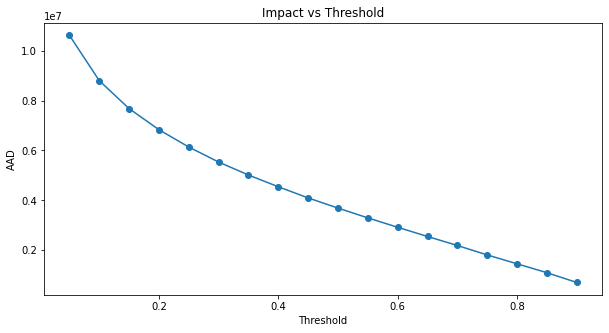

In [10]:
import matplotlib.pyplot as plt

thresholds = list(aai_agg_dict.keys())
impacts = list(aai_agg_dict.values())

plt.figure(figsize=(10, 5))
plt.plot(thresholds, impacts, marker='o')
plt.title('Impact vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('AAD')
plt.show()

### Flood impf information for exposure

In [11]:
exp.gdf['impf_FL_cima'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_CIMA)

In [12]:
exp.gdf['impf_FL_ivm'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_IVM)

### Load CF hazard

In [13]:
haz_CF_dir = Path('/cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km')

In [14]:
# get tiles covering the exposure extent
tiles = coastal_flood_hazard.find_tiles(
    exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max())

In [15]:
# load CF hazard phl
CF = coastal_flood_hazard.generate_hazard_object(tiles, haz_CF_dir, 'RCP45', '2020', 'FL')

### Caluclate impacts

#### CIMA/Capra impact functions

In [16]:
exp.gdf.rename({'impf_FL_cima' : 'impf_FL'}, axis=1, inplace=True)

In [17]:
impf_set_cf_cima = vulnerability.IMPF_SET_FL_CIMA

In [18]:
aai_agg_dict_cima = {}
for thresh in building_thresh:
    impf_set = get_TC_step_func(impf_set=impf_set_cf_cima, threshold=thresh, haz_type='FL', unit='m')
    impact = ImpactCalc(exp, impf_set, CF).impact()
    aai_agg_dict_cima[thresh] = impact.aai_agg

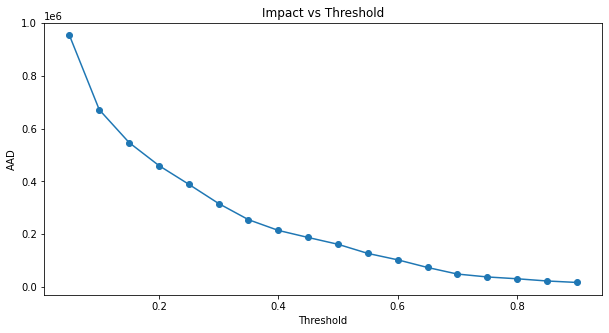

In [19]:
thresholds = list(aai_agg_dict_cima.keys())
impacts = list(aai_agg_dict_cima.values())

plt.figure(figsize=(10, 5))
plt.plot(thresholds, impacts, marker='o')
plt.title('Impact vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('AAD')
plt.show()

#### IVM impact functions

In [20]:
exp.gdf.rename({'impf_FL' : 'impf_FL_cima'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_FL_ivm' : 'impf_FL'}, axis=1, inplace=True)

In [21]:
impf_set_cf_ivm = vulnerability.IMPF_SET_FL_IVM

In [22]:
aai_agg_dict_ivm = {}
for thresh in building_thresh:
    impf_set = get_TC_step_func(impf_set=impf_set_cf_ivm, threshold=thresh, haz_type='FL', unit='m')
    impact = ImpactCalc(exp, impf_set, CF).impact()
    aai_agg_dict_ivm[thresh] = impact.aai_agg

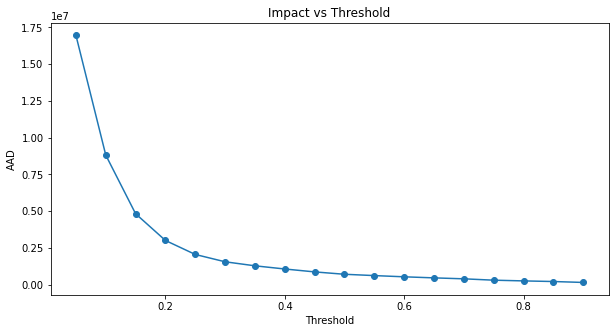

In [23]:
thresholds = list(aai_agg_dict_ivm.keys())
impacts = list(aai_agg_dict_ivm.values())

plt.figure(figsize=(10, 5))
plt.plot(thresholds, impacts, marker='o')
plt.title('Impact vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('AAD')
plt.show()